#Assignment 3.2: LSTM ASSIGNMENT

This assignment is aimed at implementing LSTMs that we had learnt in class. In this task, we'll implement a model that takes text data as input and returns the emotion behind the text.

## TEXT PRE-PROCESSING FOR NLP

**Import the dataset.**

In [11]:
#ENTER YOUR CODE HERE

In [12]:
import pandas as pd
df = pd.read_csv("new_dataset.csv")

**The dataset clearly has a large no. of redundant words, because that is simply how we humans talk. We'll first remove the stopwords.**


In [ ]:
#ENTER YOUR CODE HERE

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing resource

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        return ' '.join([word for word in words if word.lower() not in stop_words and word.isalpha()])
    return ""

df['text'] = df['text'].apply(remove_stopwords)
df[['text']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,text
0,xnausikaax oh u order horrible
1,great hard training weekend couple days rest l...
2,Right work hours go free xD
3,craving japanese food
4,Jean Michel Jarre concert tomorrow got ta work...


**Next, we'll remove some other info we dont need right now, like the handle names.**

In [ ]:
#ENTER YOUR CODE HERE

In [14]:
import re

# Function to remove Twitter handles from text
def remove_handles(text):
    if isinstance(text, str):
        return re.sub(r'@\w+', '', text)
    return ""

# Apply this function on the already cleaned 'text' column
df['text'] = df['text'].apply(remove_handles)

# Optional: remove extra spaces created after handle removal
df['text'] = df['text'].str.strip().replace(r'\s+', ' ', regex=True)

# Show updated DataFrame
df.head()


,sentiment,text
0,Negative,xnausikaax oh u order horrible
1,Negative,great hard training weekend couple days rest l...
2,Negative,Right work hours go free xD
3,Negative,craving japanese food
4,Negative,Jean Michel Jarre concert tomorrow got ta work...


**Now, we'll perform stemming, wherein we'll reduce the words to their root form.**

In [ ]:
#ENTER YOUR CODE HERE

In [15]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Initialize the stemmer
stemmer = PorterStemmer()

# Function to apply stemming
def apply_stemming(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        stemmed = [stemmer.stem(word) for word in tokens if word.isalpha()]
        return ' '.join(stemmed)
    return ""

# Apply stemming to the text column
df['text'] = df['text'].apply(apply_stemming)

# Show result
df.head()


,sentiment,text
0,Negative,xnausikaax oh u order horribl
1,Negative,great hard train weekend coupl day rest let lo...
2,Negative,right work hour go free xd
3,Negative,crave japanes food
4,Negative,jean michel jarr concert tomorrow got ta work ...


**Now that we are done with pre-processing, lets see what the gist of the data is that our model should capture.**
**Generate a word-cloud for the positive and negative words of the dataset.**

In [ ]:
#ENTER YOUR CODE HERE

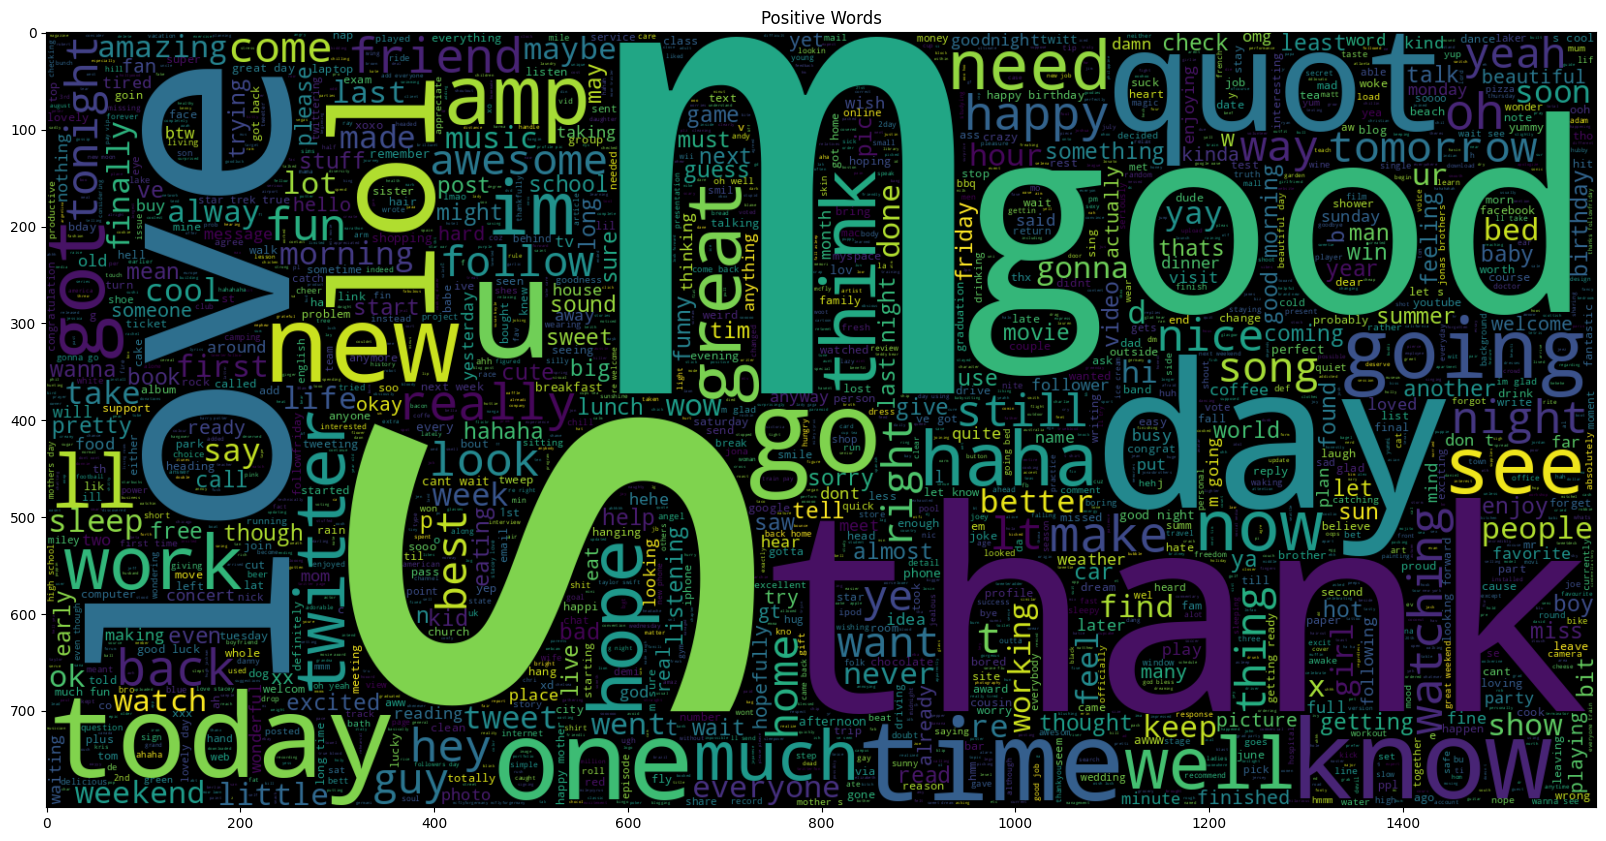

In [ ]:
#ENTER YOUR CODE HERE

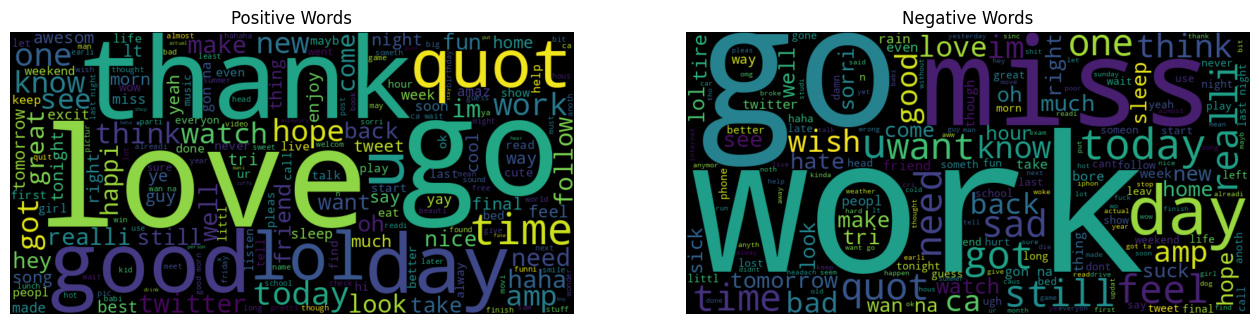

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all positive and negative tweets
positive_text = " ".join(df[df['sentiment'] == 'Positive']['text'])
negative_text = " ".join(df[df['sentiment'] == 'Negative']['text'])

# Generate word clouds
plt.figure(figsize=(16, 6))

# Positive Word Cloud
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color='black').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Words")

# Negative Word Cloud
plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Words")

plt.show()

**I'd like to point out that 'Work' is bigger in the negative words display than it is in the positive words one.**

## TRAINING

**We have now processed the data for training. It's time for us to split it into training and test splits.**

In [ ]:
#ENTER YOUR CODE HERE

In [18]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = df[:9000]
test_df = df[9000:10000]
print(len(train_df))
print(len(test_df))


9000
1000


**It is now time to convert our text sequences into numbers like the model will understand. Fit a tokenizer on the training dataset for the same. Let the vocab size be the no of unique words itself.**

In [ ]:
#ENTER YOUR CODE HERE

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)


Vocab size: 12690


**Now transform the training and testing word sequences.**

In [ ]:
#ENTER YOUR CODE HERE

In [20]:
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

print("Training data:")
print(X_train_seq[0])

print("Testing data:")
print(X_test_seq[0])


Training data:
[253, 476, 1174, 1752, 114, 7]
Testing data:
[69, 68]


**It is necessary for the simplicity of the model that each text sequence be of the same length. Pad the sequences to make this possible.**

In [ ]:
#ENTER YOUR CODE HERE

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_seq, padding='pre')
X_test_pad = pad_sequences(X_test_seq, padding='pre')

print("Training data:")
print(X_train_pad[0])

print("Testing data:")
print(X_test_pad[0])


Training data:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  253  476 1174 1752  114    7]
Testing data:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 69 68]


**Label encode y.**

In [ ]:
#ENTER YOUR CODE HERE

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(train_df['sentiment'])
y_test_enc = le.transform(test_df['sentiment'])

print("Encoded training labels:", y_train_enc[:10])
print("Encoded testing labels:", y_test_enc[:10])

Encoded training labels: [1 0 0 0 0 1 0 1 1 0]
Encoded testing labels: [1 1 1 1 1 1 0 0 1 1]


**FOLLOWING CODE IS FOR CREATING WORD EMBEDDINGS. DON'T TOUCH IT.JUST REPLACE VOCAB_SIZE WITH THE VOCABULARY SIZE OBTAINED EARLIER.**

In [28]:
import tensorflow as tf
import numpy as np
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-06-16 09:23:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-16 09:23:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-16 09:23:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zi

In [32]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '/content/best_model.keras' # Changed the extension to .keras

# Tokenize and sequence the text data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 100 # Define a maximum sequence length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['cleaned_text']) # Use cleaned text for tokenization
word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(train_df['cleaned_text'])
sequences_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

vocab_size = len(word_index) + 1 # Define vocab_size


embeddings_index = {}
f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
embedding_layer = tf.keras.layers.Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)

Found 400000 word vectors.


![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

**You should read up on why we added the previou code block.The embedding layer created is to be used in the model. Use the model summary to build the rest. Compile the model with Adam and a suitable loss function.**

In [34]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
#ENTER YOUR CODE HERE

In [36]:
from tensorflow.keras.models import Model
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Conv1D(64, kernel_size=3, padding='valid', activation='relu')(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, output)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │     3,807,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,022,745 (15.35 MB)

 Trainable params: 215,745 (842.75 KB)

 Non-trainable params: 3,807,000 (14.52 MB)

**Train the model on the train split, and validate it on the test split.**

In [40]:
#ENTER YOUR CODE
y_train = y_train_enc
y_test = y_test_enc


In [41]:
MODEL_PATH = '/content/best_model.keras'

checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint]
)



Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5482 - loss: 0.6846
Epoch 1: val_loss improved from inf to 0.66096, saving model to /content/best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5510 - loss: 0.6836 - val_accuracy: 0.6290 - val_loss: 0.6610
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6500 - loss: 0.6337
Epoch 2: val_loss improved from 0.66096 to 0.61598, saving model to /content/best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.6507 - loss: 0.6329 - val_accuracy: 0.6760 - val_loss: 0.6160
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6771 - loss: 0.5984
Epoch 3: val_loss improved from 0.61598 to 0.60108, saving model to /content/best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6775 - loss: 0.5978 - val_accuracy: 0.6880 - val_loss: 0.6011
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7009 - loss: 0.5722
Epoch 4: val_loss improved from 0.60108 to 0.59354, saving 

**Let's visualise the model's training history now.**

In [ ]:
#ENTER YOUR CODE HERE

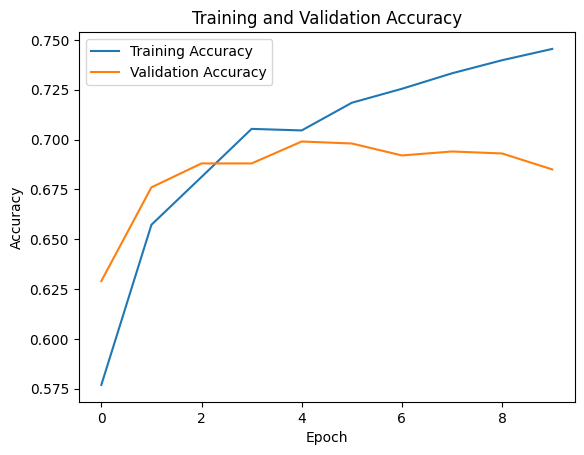

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#ENTER YOUR CODE HERE

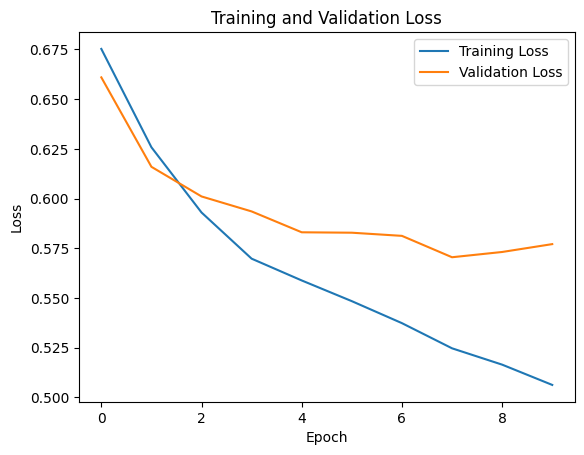

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Lets see what the accuracy of the model is.**

In [ ]:
#ENTER YOUR CODE HERE

In [44]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step
              precision    recall  f1-score   support

           0       0.64      0.79      0.71       481
           1       0.75      0.59      0.66       519

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.68      1000
weighted avg       0.70      0.69      0.68      1000



**Take a random input sequence from the text series. First predict on it nd gets its sentiment. Then decode the string using the tokenizer, etc. you've developed and print the string as well.**

In [ ]:
#ENTER YOUR CODE HERE

In [46]:
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np # Import numpy

idx = random.randint(0, len(X_test) - 1)
sequence = X_test[idx]
original_label = y_test[idx]

predicted_prob = model.predict(np.expand_dims(sequence, axis=0))
predicted_label = (predicted_prob > 0.5).astype(int)

le = LabelEncoder()
le.fit(df['sentiment']) # Fit the LabelEncoder on the 'sentiment' column

decoded_predicted = le.inverse_transform(predicted_label.ravel())[0]
decoded_actual = le.inverse_transform([original_label])[0]

reverse_word_index = dict((i, word) for word, i in tokenizer.word_index.items())
decoded_text = ' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0])

print("The chosen sequence is:", sequence)
print("The predicted sentiment is:", [decoded_predicted])
print("The original sentiment is:", [decoded_actual])
print("The decoded text is:", decoded_text) # Print the decoded text

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
The chosen sequence is: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 348 804 531 116 320  14]
The predicted sentiment is: ['Negative']
The original sentiment is: ['Negative']
The decoded text is: tommcfli tom freak pleas repli miss


In [ ]:
#ENTER YOUR CODE HERE

['dad', 'fever', 'again', 'not', 'looking', 'good']


**We can try this on a random string as well.**

In [ ]:
input_str="I hate everyone on earth!"
#ENTER YOUR CODE HERE

In [47]:
input_str = "I hate everyone on earth!"

input_seq = tokenizer.texts_to_sequences([input_str])
input_seq_padded = pad_sequences(input_seq, maxlen=MAX_SEQUENCE_LENGTH)

predicted_prob = model.predict(input_seq_padded)
predicted_label = (predicted_prob > 0.5).astype(int)

decoded_predicted = le.inverse_transform(predicted_label.ravel())[0]

print("The predicted sentiment is:", [decoded_predicted])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
The predicted sentiment is: ['Negative']


## GOOD JOB!